# Assignment 5

### Intro
In this assignment, you will design a Convolutional Neural Network (CNN) based algorithm that can automatically identify hand-written digits.

We will be using the Keras API to design our CNN. Keras is a high-level library that builds on top of lower-level libraries like Tensorflow and Theano. In other words, Keras can be thought of as a front-end API which uses a backend engine for its computations. For example, we can use Keras with a Tensorflow or Theano backend. Since Keras does not yet support PyTorch, we will be using the Tensorflow backend (Theano is not widely used anymore). Follow the README to install both Tensorflow and Keras.

The nice thing about APIs like Keras is that we can create models quickly without having to worry about the underlying implementation. However, for highly customzed algorithms it is usually necessary to work with the lower-level libraries like PyTorch or Tensorflow.

You should definitely read this before attempting this assignment: https://keras.io/getting-started/sequential-model-guide/

Essentially Keras has two ways of defining a model: Sequentially or Functionally. We use the sequential approach in this assignment but you are more than welcome to try the functional approach as this is more commonly used.

### Background
The dataset we will use is a variant of the orignal MNIST handwritten digit dataset. In this variant, each image (input) contains two or three digits from the original MNIST dataset randomly scaled to 40/60/80/100/120 percent of the original digit size and spliced together at different angles.

For each image in the modified dataset, the correct label corresponds to the digit with the maximum area. More precisely, this area refers to area of the rectangle which encompasses the digit.

We will use 39999 images for training and 10000 images for testing.

Download the dataset files here:

[Features](https://drive.google.com/file/d/1ZWQN6Y4Pm70k25ONmDOgbZOwVGhBITov/view?usp=sharing)

[Labels](https://drive.google.com/file/d/11I7RgSYMhF5bWGDMRFOiEkeQ-DyZjhAj/view?usp=sharing)

### Your task
Your task for this assignment is to improve the base model and achieve an accuracy of 95% or above on the test set. You will do this by making the model more complex by doing the following:
1. Changing the architecture of the model by adding Conv2d, Dense(feed-forward), Pooling, [Dropout](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5), and any other layers that make sense.
2. Playing around the parameters of the layers. Do some quick research to see what kind of pooling, for example, could be effective in this task and experiment!
3. Modify the preprocess function if you think you can do better

### Note:
This assignment may take a while to complete (mostly due to training time). If you find that it is taking too long, reduce the batch size (to some lower power of 2) and reduce the number of epochs from 10 to a lower number. Whatever accuracy you end up with does not matter as long as we see that you have tried you complete this assignment :)

In [1]:
# Python imports
import os

# Data manipulation imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import scipy as sp


# ML Imports
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.models import Model
from keras.layers import InputLayer
from keras.layers import Reshape, MaxPooling2D, ZeroPadding2D, Dropout
from keras.layers import Conv2D, Dense, Flatten, Input
from keras.utils import to_categorical

# IPython display
from IPython.display import display

Using TensorFlow backend.


### First we declare some constants relating to our input and training

In [0]:
BATCH_SIZE = 512 # Reduce this to 256, 128, 64, etc if your computer is too slow
IMG_SIZE = 64 # Images are 64x64
NUM_CHANNELS = 1 # Images can have multiple channels eg. rgb. These images are grayscale so we have just 1 channel
NUM_CLASSES = 10 # Digits 0-9, so we have 10 classes

IMG_SIZE_FLAT = IMG_SIZE ** 2 # 64^2 = 4096, the number of pixels per image
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
IMG_SHAPE_CHANNELS = (IMG_SIZE, IMG_SIZE, NUM_CHANNELS)
INPUT_SHAPE = (-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS)

### Helper functions

In [0]:
def preprocess(x):
    '''
    Simple preprocessing function that removes the background from the images and normalizes pixel values between 0 and 1
    :param x: Input array or dataframe
    '''
    x[x < 255] = 0 # Remove background
    x = x / 255.0 # normalize
    '''
    for sample in x:
      np.reshape(sample, (64, 64))
      sample = sp.ndimage.binary_erosion(sample).astype(sample.dtype)
      np.reshape(sample, (64, 64, 1))
    
    '''
    return x

def show_data(X, y_true=None, y_pred=None, n_examples=10, shape=IMG_SHAPE):
    '''
    Displays the images X along with actual and predicted labels if provided.
    :param X: The array of images.
    :param y_true: The true labels
    :param y_pred: The predicted labels
    :param n_examples: The number of images to show.
    :param shape: If images are flattened, reshapes to shape
    :return: None
    '''
    for i in range(n_examples):
        image = np.array(X[i], dtype=np.float32)
        pixels = image.reshape(shape)
        plt.imshow(pixels, cmap='binary')
        plt.xlabel('Actual: {} Pred: {}'.format(y_true[i] if y_true is not None else None, 
                                                y_pred[i] if y_pred is not None else None))
        plt.show()

def predict(model, X):
    '''
    Given a Keras model, performs prediction and computes the labels
    :param model: Keras model
    :param X: Input features
    :return: Predicted labels
    '''
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    return y_pred

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
X = pd.read_csv('/content/drive/My Drive/Colab Notebooks/modified_mnist_x.csv', dtype=np.float32)
y = pd.read_csv('/content/drive/My Drive/Colab Notebooks/modified_mnist_y.csv', dtype=np.float32)

In [69]:
display(X.head())
display(y.head())

,149.000000,155.000000,154.000000,158.000000,158.000000.1,156.000000,156.000000.1,158.000000.2,156.000000.2,153.000000,...,182.000000.30,179.000000.109,173.000000.140,181.000000.67,185.000000.17,184.000000.19,181.000000.68,177.000000.119,174.000000.129,173.000000.141
0,52.0,54.0,55.0,37.0,37.0,37.0,37.0,38.0,38.0,38.0,...,36.0,39.0,40.0,38.0,37.0,40.0,43.0,42.0,55.0,55.0
1,109.0,113.0,117.0,116.0,110.0,102.0,94.0,91.0,101.0,109.0,...,82.0,85.0,86.0,96.0,118.0,119.0,108.0,95.0,74.0,71.0
2,176.0,177.0,177.0,177.0,169.0,159.0,158.0,167.0,175.0,188.0,...,170.0,171.0,142.0,118.0,115.0,120.0,108.0,80.0,41.0,29.0
3,64.0,29.0,30.0,30.0,32.0,32.0,32.0,35.0,30.0,32.0,...,35.0,37.0,38.0,33.0,119.0,101.0,39.0,45.0,48.0,52.0
4,123.0,123.0,123.0,121.0,117.0,111.0,105.0,101.0,100.0,115.0,...,61.0,56.0,58.0,57.0,57.0,57.0,57.0,55.0,51.0,49.0


,4
0,7.0
1,1.0
2,0.0
3,8.0
4,7.0


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [99]:
display(X_train.shape)
display(X_test.shape)

(39999, 4096)

(10000, 4096)

### First we reshape the flattenend images into 64x64x1 (The 1 is because we have 1 channel. If we had rgb, then it would be 64x64x3)

In [0]:
X_train = np.reshape(X_train.values, INPUT_SHAPE)
X_test = np.reshape(X_test.values, INPUT_SHAPE)
y_train = y_train.values
y_test = y_test.values

In [0]:
print(type(X_train[1]))
print(X_train[1])

<class 'numpy.ndarray'>
[[[132.]
  [138.]
  [ 79.]
  ...
  [147.]
  [ 71.]
  [ 40.]]

 [[132.]
  [133.]
  [ 70.]
  ...
  [115.]
  [ 48.]
  [ 30.]]

 [[134.]
  [128.]
  [ 58.]
  ...
  [ 49.]
  [ 34.]
  [ 32.]]

 ...

 [[ 32.]
  [ 36.]
  [ 37.]
  ...
  [ 78.]
  [ 82.]
  [ 66.]]

 [[ 27.]
  [ 34.]
  [ 38.]
  ...
  [ 79.]
  [ 76.]
  [ 84.]]

 [[ 24.]
  [ 33.]
  [ 38.]
  ...
  [ 72.]
  [ 64.]
  [ 97.]]]


### Let's take a look at our data

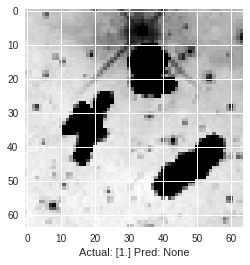

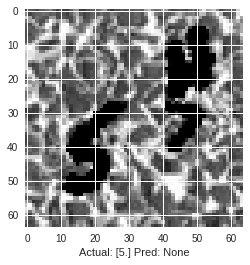

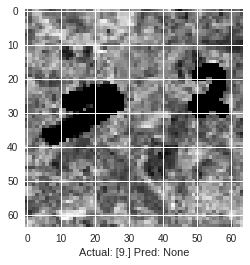

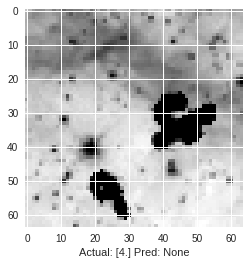

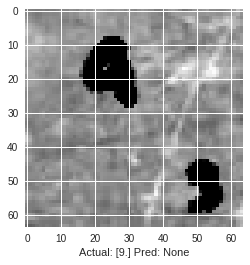

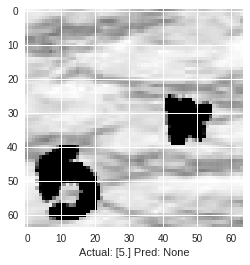

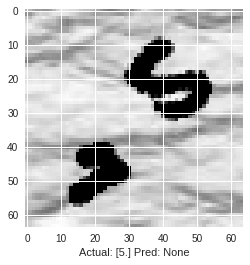

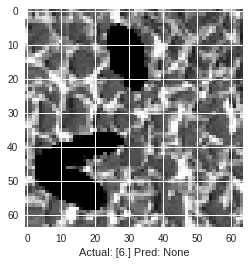

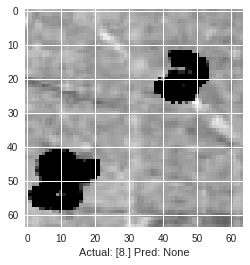

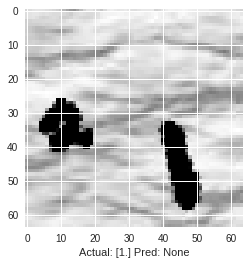

In [73]:
show_data(X_train, y_train)

### We notice that the digits themselves are always black, and the backgrounds are of a different shade. This implies we could remove the background. Let's do that

In [0]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [16]:
display(X_train.shape) # Now our inputs have been reshaped, so we have a 4D array, with each item representing an image.
display(X_test.shape)

(39999, 64, 64, 1)

(10000, 64, 64, 1)

### Categorical labels should always be one-hot encoded

In [0]:
y_train_enc = to_categorical(y_train, NUM_CLASSES)
y_test_enc = to_categorical(y_test, NUM_CLASSES)

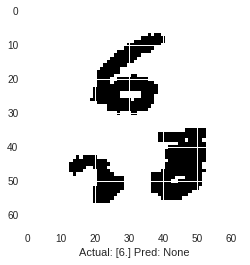

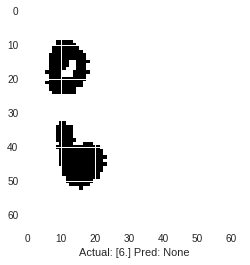

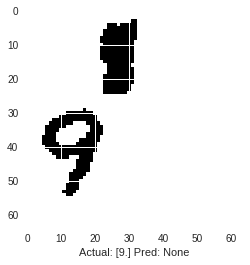

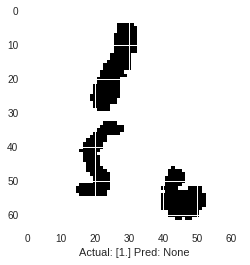

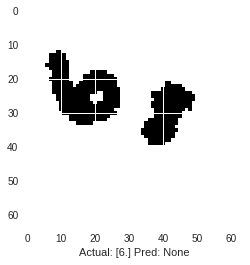

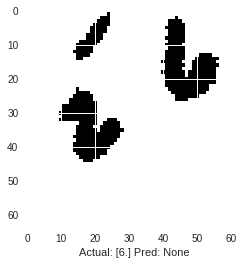

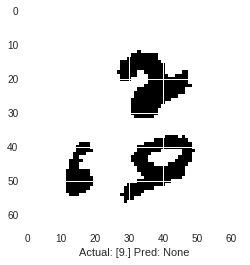

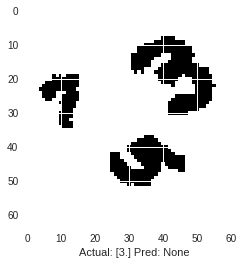

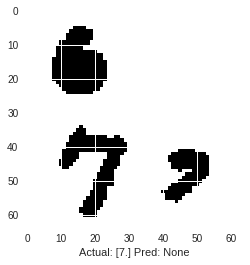

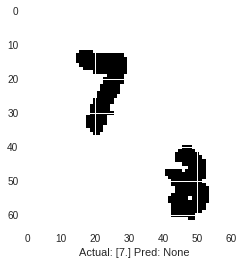

In [0]:
show_data(X_train, y_train)

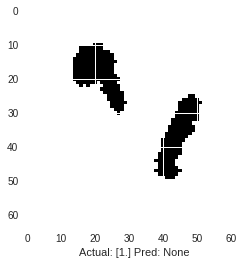

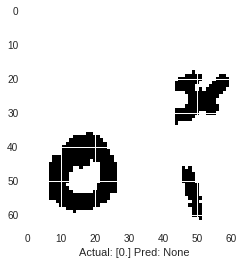

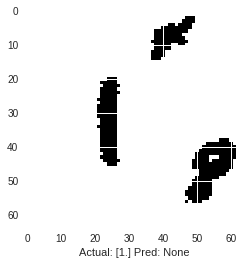

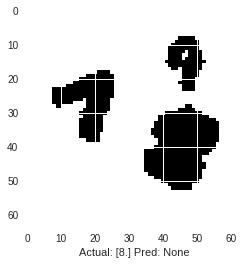

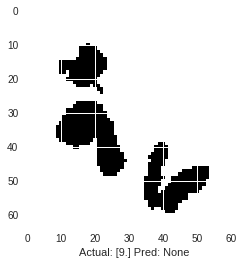

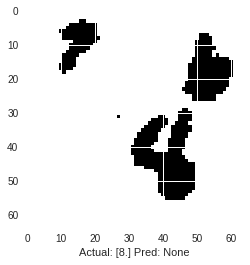

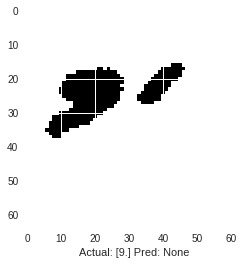

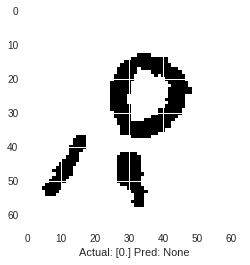

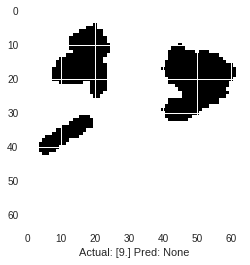

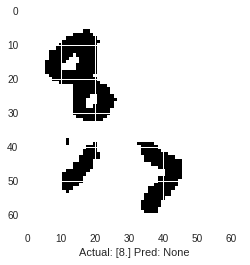

In [0]:
show_data(X_test, y_test)

### Now we define our base model

This is a very simple CNN architecture similar to what you learned in the lecture. We have cascading blocks of convolutional layers followed by pooling layers.

In [0]:
def create_base_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=IMG_SHAPE_CHANNELS))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))

    model.add(Dense(1024, activation='relu'))

    model.add(Dense(NUM_CLASSES, activation='softmax'))

    return model

In [0]:
model_base = create_base_model()
model_base.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model_base.fit(x=X_train, y=y_train_enc, epochs=10, batch_size=BATCH_SIZE)

Epoch 1/10
39999/39999 [==============================] - 187s 5ms/step - loss: 2.3038 - acc: 0.1531
Epoch 2/10
39999/39999 [==============================] - 181s 5ms/step - loss: 1.5024 - acc: 0.4812
Epoch 3/10
39999/39999 [==============================] - 184s 5ms/step - loss: 0.6149 - acc: 0.8061
Epoch 4/10
25856/39999 [==================>...........] - ETA: 9:56 - loss: 0.3403 - acc: 0.8957 

KeyboardInterrupt: 

In [0]:
y_pred = predict(model_base, X_test)

## Your task

Complete the create_model function which will return a Keras model. You may use either the Sequential or Functional Keras API.

Compile your model and fit the training set as shown above. Predict on the test set and check your accuracy.


In [0]:
def create_model():
    # TODO: Create your model here
    #implementing functional model
    '''
    **I've been trying to implement a functional model but the training accuracy doesn't get past ~91% after 10 epochs
    I'm not sure if it's an issue with my implementation or I'm not training enough epochs (although it seems to be stabilizing)
    Here's my code below but I just ended up using a sequential model for this assignment:
    
    inputs = Input(shape=IMG_SHAPE_CHANNELS)

    x = Conv2D(32, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Dropout(0.1)(x)
    
    x = Flatten()(x)
    
    #x = Dense(512, activation='relu')(x)
    #x = Dropout(0.4)(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    output = Dense(NUM_CLASSES, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=output)
    '''
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=IMG_SHAPE_CHANNELS))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    print(model.summary())
    return model

In [20]:
model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 128)         73856     
__________

In [21]:
# TODO: fit your model to the training set
model.fit(x=X_train, y=y_train_enc, epochs=12, batch_size=BATCH_SIZE)

Epoch 1/12
39999/39999 [==============================] - 306s 8ms/step - loss: 2.1791 - acc: 0.1856
Epoch 2/12
39999/39999 [==============================] - 304s 8ms/step - loss: 1.5919 - acc: 0.4438
Epoch 3/12
39999/39999 [==============================] - 303s 8ms/step - loss: 1.0099 - acc: 0.6669
Epoch 4/12
39999/39999 [==============================] - 304s 8ms/step - loss: 0.7014 - acc: 0.7742
Epoch 5/12
39999/39999 [==============================] - 304s 8ms/step - loss: 0.5408 - acc: 0.8277
Epoch 6/12
39999/39999 [==============================] - 302s 8ms/step - loss: 0.4275 - acc: 0.8656
Epoch 7/12
39999/39999 [==============================] - 303s 8ms/step - loss: 0.3570 - acc: 0.8855
Epoch 8/12
39999/39999 [==============================] - 303s 8ms/step - loss: 0.2900 - acc: 0.9065
Epoch 9/12
39999/39999 [==============================] - 304s 8ms/step - loss: 0.2536 - acc: 0.9152
Epoch 10/12
39999/39999 [==============================] - 303s 8ms/step - loss: 0.2140 - a

In [22]:
 y_pred = predict(model, X_test)
print('Your accuracy is:', accuracy_score(y_test, y_pred))

#Achieved 95% training accuracy -- overfit...

Your accuracy is: 0.9011
